<a href="https://colab.research.google.com/github/ipavlopoulos/palit/blob/main/code/fcnnc--mod13-split.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Import libraries

In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset, TensorDataset

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import skimage
from skimage import transform
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import *
from sklearn.model_selection import GroupShuffleSplit, train_test_split
from sklearn.metrics import confusion_matrix
import xgboost as xgb

from tqdm.notebook import tqdm
import os
import random

#### Classifier and training Utilities

In [2]:
class CNNCLF(nn.Module):
    def __init__(self, n_classes):
        super().__init__()

        self.CNN = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=0),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(32),

            nn.Conv2d(32, 64, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),
        )

        self.MLP = nn.Sequential(
            nn.Linear(41472, 1024, bias=True),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(1024),
            nn.Dropout(p=0.1, inplace=True),

            nn.Linear(1024, 512, bias=True),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(512),
            nn.Dropout(p=0.1, inplace=True),

            nn.Linear(512, n_classes, bias=True)
        )

    def forward(self, x):
        x = self.CNN(x.unsqueeze(1))
        x = torch.flatten(x, 1)
        x = self.MLP(x)
        return x

In [3]:
# the model predicts the average - high variance
def validate_clf(model, dataloader, device="cpu", criterion = nn.CrossEntropyLoss()):
    prediction_list, labels_list = [], []
    model.eval()
    loss = 0
    with torch.no_grad():
        for id_batch, (inputs, labels) in enumerate(dataloader):
            inputs, labels = inputs.to(device), labels.to(device)
            model.to(device)
            outputs = model(inputs)
            loss += criterion(outputs, labels).item()
            labels = np.argmax(labels.cpu().detach().numpy(), axis=1)
            predictions = np.argmax(outputs.cpu().detach().numpy(), axis=1)
            prediction_list.append(predictions)
            labels_list.append(labels)
    p = np.concatenate(prediction_list)
    g = np.concatenate(labels_list)
    acc = accuracy_score(g, p)
    return p, g, loss, acc

def train_clf(model, dataloader, optimizer, criterion=nn.CrossEntropyLoss(), val_dataloader=None, patience=3, N_EPOCHS=100, device="cpu"):
    losses, mae_losses, val_losses, train_losses = [], [], [], []
    dataset_size = len(dataloader.dataset)
    lowest_error = 100000
    best_epoch = -1

    for epoch in range(N_EPOCHS):
        print(f"\nEpoch {epoch + 1}\n-------------------------------")
        train_loss = 0
        # Loop over batches in an epoch using DataLoader
        for id_batch, (inputs, labels) in enumerate(dataloader):
            model.train()
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        if val_dataloader is not None:
            if (patience>0) and (epoch-best_epoch>patience-1) and epoch > 50:
                print("Max patience reached, now loading the best checkpoint...")
                model.load_state_dict(torch.load("checkpoint.pt"))
                print("Exiting...")
                break
            predictions, labels, val_loss, val_acc = validate_clf(model, val_dataloader, device=device)
            val_losses.append(val_loss)
            train_losses.append(train_loss)
            # ignore majority perfomance
            if (patience>0) and (val_loss<lowest_error):
                lowest_error = val_loss
                best_epoch = epoch
                torch.save(model.state_dict(), "checkpoint.pt")
            print(f"Train loss: {train_loss:.2f}, Val loss: {val_loss:.2f}, Val acc: {val_acc:.2f}")
            print(f"Best Epoch: {best_epoch+1} (Val loss: {lowest_error:.2f})")
            print(f"[val var: {np.var(predictions):.2f}, min-max: {min(predictions):.2f}-{max(predictions):.2f}]")
    model.eval()
    return model, train_losses, val_losses

#### Data

In [4]:
class ImageDataset(TensorDataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.labels = np.array(self.dataframe['date'])
        self.labels = np.reshape(self.labels, (self.labels.shape[0], 1))
        self.labels = OneHotEncoder(sparse=False).fit_transform(self.labels)

    def __len__(self):
        return self.dataframe.shape[0]

    def __getitem__(self, idx):
        sample, date = self.dataframe.iloc[idx].img.astype(np.float32), self.labels[idx]
        if self.transform is not None:
            sample = self.transform(sample)
            sample = sample.reshape(sample.shape[1], sample.shape[2]) # grayscale
        return sample, date # 1CE-4CE

In [5]:
# ACTION needed: download the data (with gdown or re-create using PaLit.xlsx)
!gdown 1kNgqJCFZS4Q-P2YSaeaYp9P2bTobyOCV
pll = pd.read_pickle("pll.csv")

Downloading...
From: https://drive.google.com/uc?id=1kNgqJCFZS4Q-P2YSaeaYp9P2bTobyOCV
To: /content/pll.csv
100% 1.44G/1.44G [00:12<00:00, 117MB/s]


In [13]:
dataset = pll.explode("img")
dataset = dataset[dataset.img.notna()]
dataset.sample()

,uid,date,quarter,filename_enc,filename_websafe,img
11,12,1,4,1stAD_P.Oxy. 3466.jpg,1stAD_P.Oxy.%203466.jpg,"[[0.43477137254901965, 0.39555568627450977, 0...."


In [14]:
print("Lines num:", dataset.shape[0])

w,h = 300,50
img_data = pd.DataFrame(dataset.img.apply(lambda x: x.shape).tolist(), index=dataset.index, columns=["H", "W"])
dataset = dataset[(img_data.W>w)&(img_data.H>h)]
dataset.insert(0, "lid", range(1, dataset.shape[0]+1))

Lines num: 4717


# Dataset split


In [15]:
# disregard fragments and split the lines
#pll_train, pll_test = train_test_split(dataset, test_size=0.1, random_state=2023)
#pll_train, pll_val = train_test_split(pll_train, test_size=pll_test.shape[0], random_state=2023)
#print(pll_train.shape[0], pll_val.shape[0], pll_test.shape[0])

In [16]:
dataset.date.value_counts(normalize=True)*100

2    42.213410
3    38.392213
1    12.653208
4     6.741168
Name: date, dtype: float64

In [17]:
dataset = dataset.sample(frac=1)
pll_train = dataset[dataset.uid.apply(lambda x: x%13!=0)]
pll_test = dataset[dataset.uid.apply(lambda x: x%13==0)]
pll_val = pll_test.iloc[:pll_test.shape[0]//2]

2615 159 79


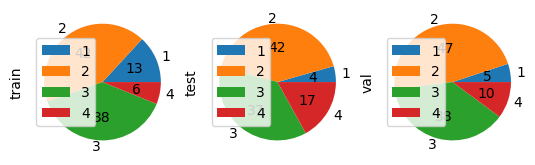

In [18]:
print(pll_train.shape[0], pll_test.shape[0], pll_val.shape[0])
pd.DataFrame({'train':pll_train.date.value_counts(),
              'test': pll_test.date.value_counts(),
              'val': pll_val.date.value_counts()}).plot.pie(subplots=True, autopct=f'%.0f');

In [19]:
augment = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomAffine(3), # turn
    transforms.RandomResizedCrop((50, 300), scale=(0.75, 1.0), ratio=(1, 6)), # crop n scale (add scale to control this)
    #transforms.RandomCrop((30, 30)),
    transforms.GaussianBlur(3), # blur
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.5, value=0.5), # erase
])

cc_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.CenterCrop((50, 300)),
    transforms.ToTensor(),
])

rs_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((50,300)),
    transforms.ToTensor(),
])

white_fragment_ablation = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((50,300)),
    transforms.ToTensor(),
    transforms.RandomErasing(p=1, value=0), # erase
])

black_fragment_ablation = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((50,300)),
    transforms.ToTensor(),
    transforms.RandomErasing(p=1, value=1), # erase
])

#### Load Model

In [ ]:
#model = Classifier(n_classes=4)
#model.load_state_dict(torch.load('./checkpoint.pt'))

### Training Procedure

In [20]:
epochs, batch_size, device, n_classes, lr, patience = 150, 16, "cuda", 4, 1e-3, 10
dataloader = DataLoader(ImageDataset(pll_train, transform=augment), batch_size=batch_size, drop_last=False, shuffle=True)
val_dataloader = DataLoader(ImageDataset(pll_val, transform=rs_transform), batch_size=batch_size, drop_last=False)
model = CNNCLF(n_classes=n_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
model, train_losses, val_losses = train_clf(device=device, dataloader=dataloader, model=model, optimizer=optimizer, N_EPOCHS=epochs, val_dataloader=val_dataloader, patience=patience)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(



Epoch 1
-------------------------------
Train loss: 196.89, Val loss: 6.76, Val acc: 0.25
Best Epoch: 1 (Val loss: 6.76)
[val var: 0.18, min-max: 0.00-1.00]

Epoch 2
-------------------------------
Train loss: 174.24, Val loss: 5.58, Val acc: 0.38
Best Epoch: 2 (Val loss: 5.58)
[val var: 0.00, min-max: 2.00-2.00]

Epoch 3
-------------------------------
Train loss: 173.95, Val loss: 4.96, Val acc: 0.72
Best Epoch: 3 (Val loss: 4.96)
[val var: 0.24, min-max: 1.00-2.00]

Epoch 4
-------------------------------
Train loss: 169.22, Val loss: 5.07, Val acc: 0.65
Best Epoch: 3 (Val loss: 4.96)
[val var: 0.15, min-max: 1.00-2.00]

Epoch 5
-------------------------------
Train loss: 167.05, Val loss: 4.75, Val acc: 0.70
Best Epoch: 5 (Val loss: 4.75)
[val var: 0.21, min-max: 1.00-2.00]

Epoch 6
-------------------------------
Train loss: 159.38, Val loss: 6.97, Val acc: 0.47
Best Epoch: 5 (Val loss: 4.75)
[val var: 0.00, min-max: 1.00-1.00]

Epoch 7
-------------------------------
Train loss:

# Eval

<Axes: >

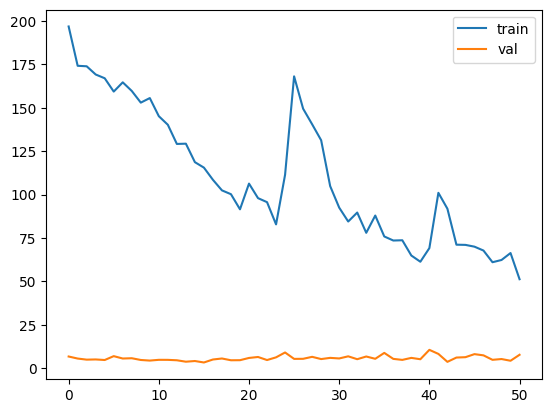

In [21]:
pd.DataFrame({"train": train_losses, "val": [float(v) for v in val_losses]}, index=range(len(train_losses))).plot()

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Acc: 0.77
              precision    recall  f1-score   support

           0       0.78      1.00      0.88         7
           1       0.76      0.80      0.78        66
           2       0.78      0.92      0.84        59
           3       0.73      0.30      0.42        27

    accuracy                           0.77       159
   macro avg       0.76      0.75      0.73       159
weighted avg       0.76      0.77      0.75       159



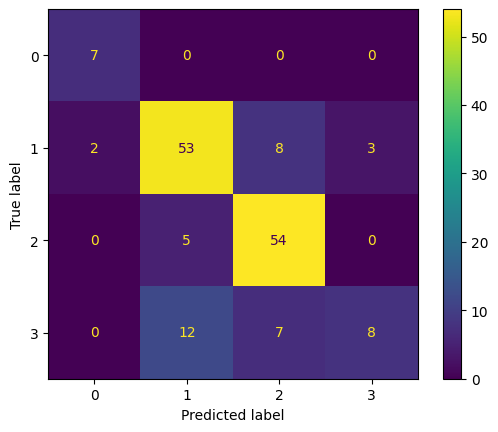

In [22]:
test_loader = DataLoader(ImageDataset(pll_test, transform=rs_transform), batch_size=1)
predictions, labels, loss, acc = validate_clf(model, test_loader)
print(f'Acc: {acc:.2f}')
print(classification_report(labels, predictions))
ax = ConfusionMatrixDisplay.from_predictions(labels, predictions);
ax.figure_.savefig('confusion.pdf', format='PDF', dpi=300)

# Saliency

In [23]:
# !rm -R heatmaps
!mkdir heatmaps
dataloader = DataLoader(ImageDataset(pll_test, transform=rs_transform), batch_size=1)
device = 'cpu'
criterion = nn.CrossEntropyLoss().to(device)
model.eval()
for batch_index, (batch, labels) in enumerate(dataloader):
    batch = batch.to(device)
    labels = labels.to(device)
    batch = batch.requires_grad_(requires_grad=True)

    output = model(batch).to(device)
    loss = criterion(output, labels)

    loss.backward()

    batch_grad = batch.grad.cpu().detach().numpy()
    batch_grad = np.squeeze(batch_grad)
    batch_grad = np.absolute(batch_grad)

    fig, axs = plt.subplots(2, 1, figsize=(10, 5))
    axs[0].imshow(batch_grad, cmap='hot', interpolation='nearest')
    axs[1].imshow(np.squeeze(batch.cpu().detach().numpy()), cmap='gray')

    # plt.colorbar()
    plt.savefig(f'./heatmaps/heatmap_{batch_index:d}-DATE:{pll.iloc[batch_index].date}-PRED:{np.argmax(output.detach(), 1)}')
    plt.close()

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


# Ablation

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


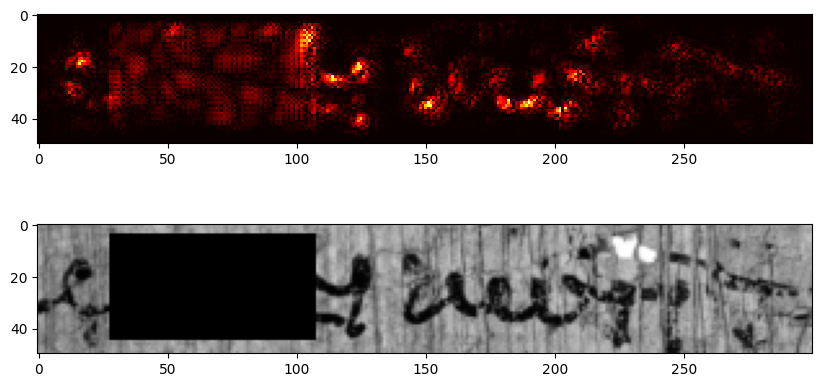

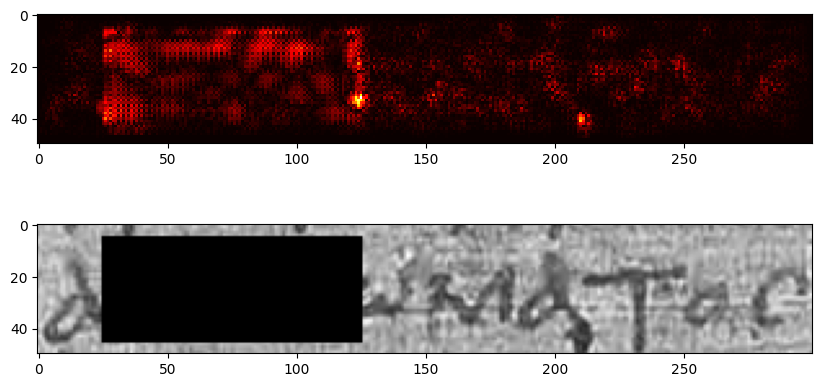

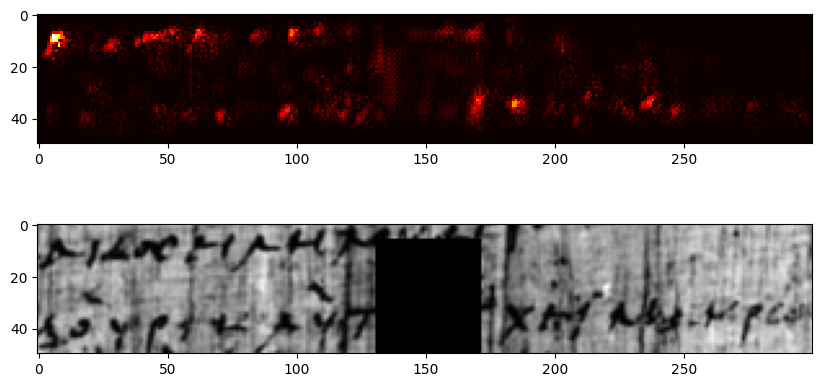

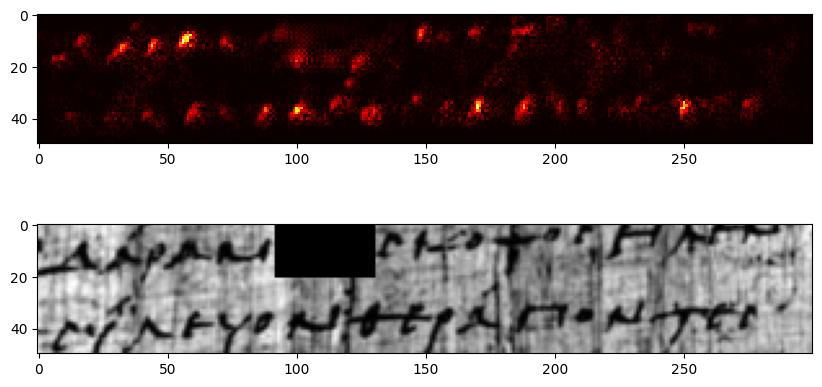

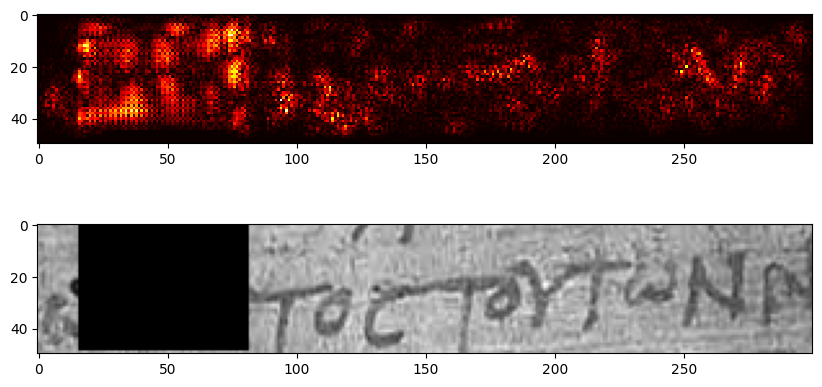

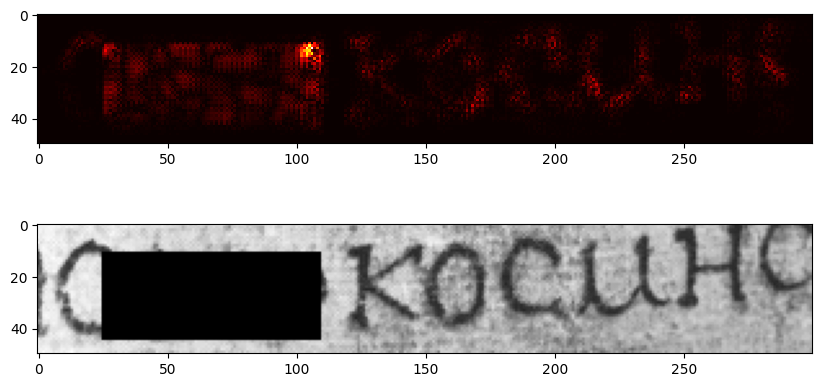

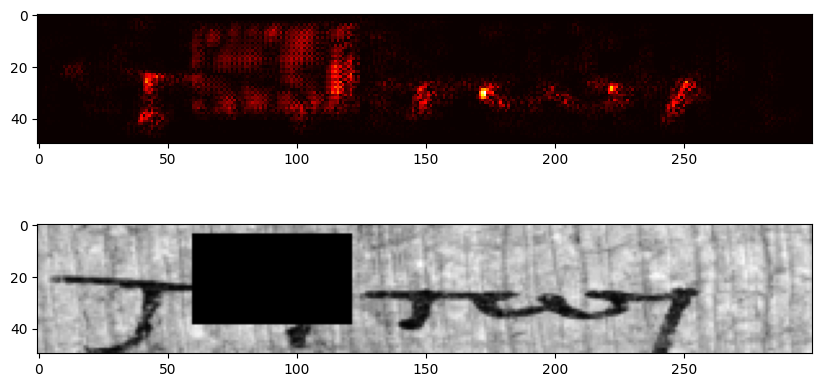

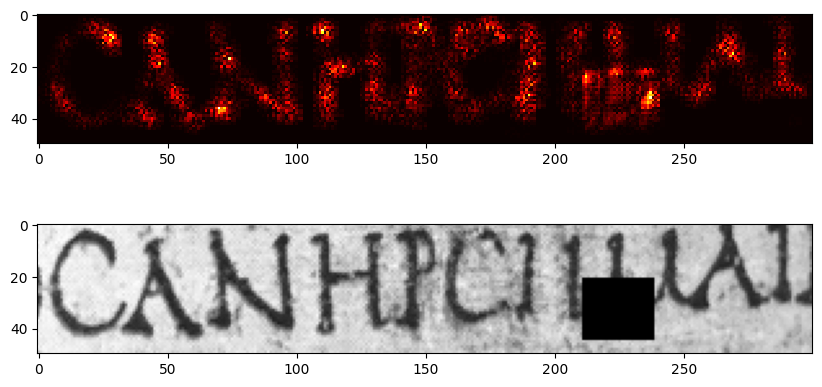

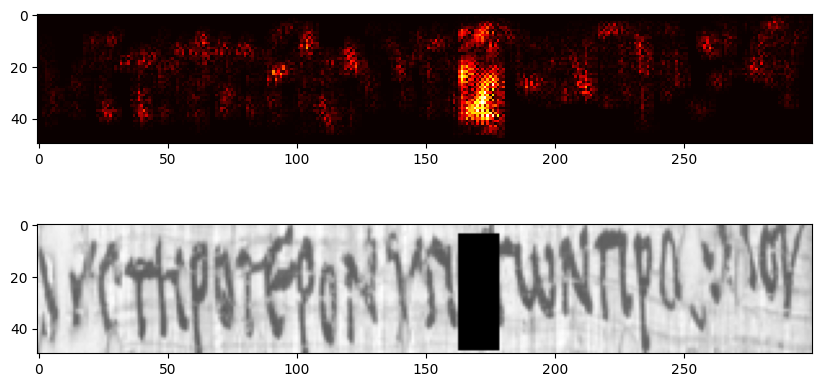

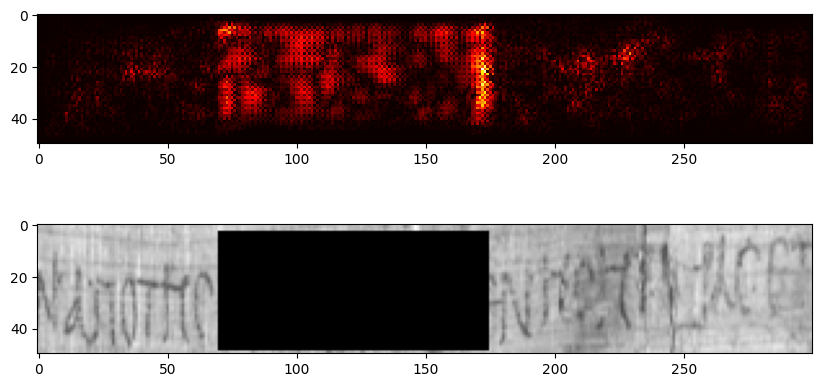

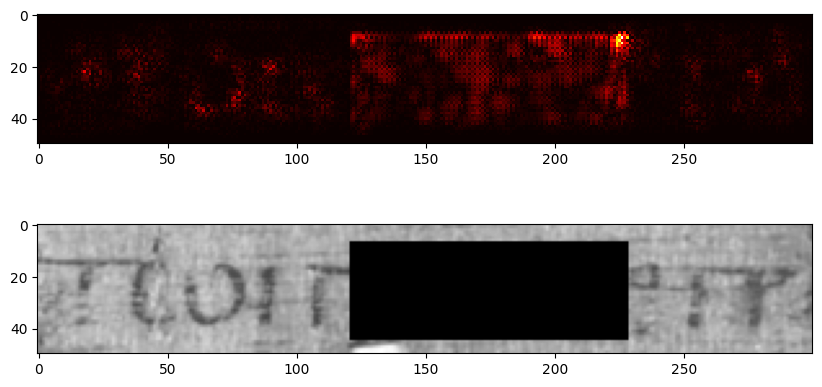

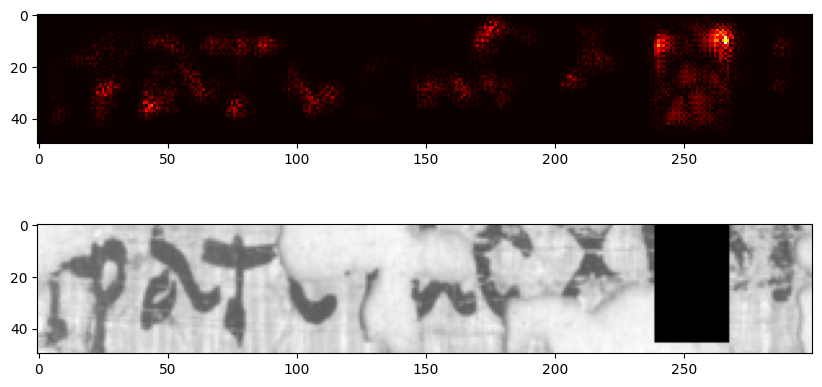

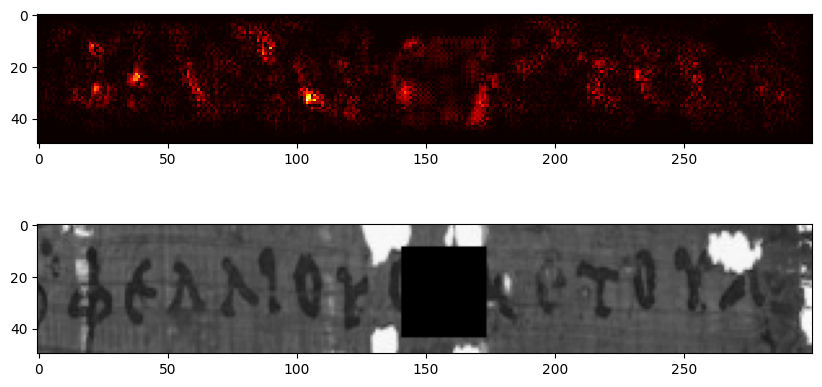

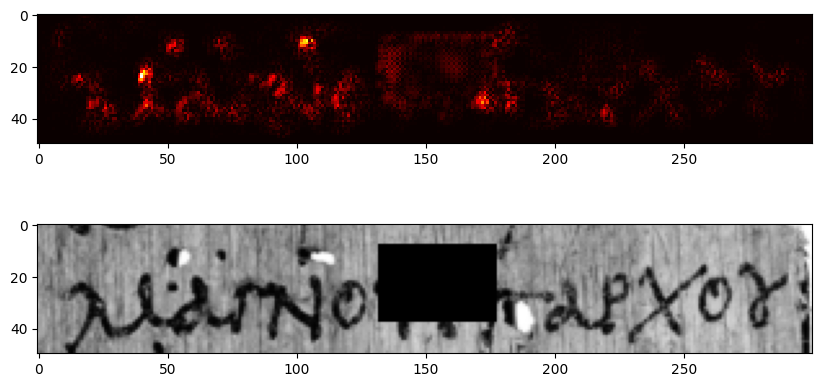

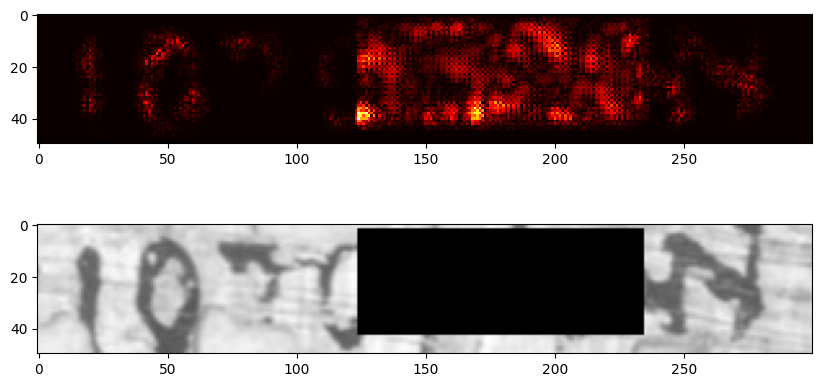

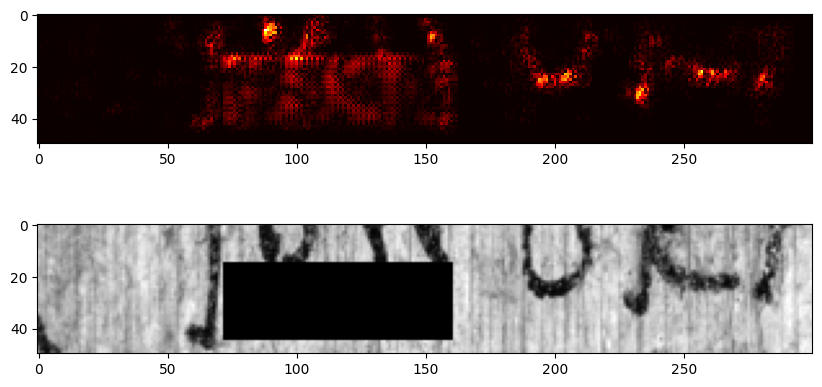

In [24]:
dataloader = DataLoader(ImageDataset(pll_test.iloc[:batch_size], transform=white_fragment_ablation), batch_size=1)
device = 'cpu'
criterion = nn.CrossEntropyLoss().to(device)
model.eval()
for batch_index, (batch, labels) in enumerate(dataloader):
    batch = batch.to(device)
    labels = labels.to(device)
    batch = batch.requires_grad_(requires_grad=True)

    output = model(batch).to(device)
    loss = criterion(output, labels)

    loss.backward()

    batch_grad = batch.grad.cpu().detach().numpy()
    batch_grad = np.squeeze(batch_grad)
    batch_grad = np.absolute(batch_grad)

    fig, axs = plt.subplots(2, 1, figsize=(10, 5))
    axs[0].imshow(batch_grad, cmap='hot', interpolation='nearest')
    axs[1].imshow(np.squeeze(batch.cpu().detach().numpy()), cmap='gray')

    plt.show()
    plt.close()